In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
path_to_images = '/content/drive/MyDrive/video_images'
import os 

list_of_file_paths = []

number_files_in_folder = len(os.listdir(path_to_images))
for index in range(number_files_in_folder):
  single_file_path = os.path.join(path_to_images, f'{index}.jpg')
  # print(single_file_path)
  list_of_file_paths.append(single_file_path)

In [3]:
list_of_file_paths[0]

'/content/drive/MyDrive/video_images/0.jpg'

In [4]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything 
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything


/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1185, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1185 (delta 11), reused 11 (delta 4), pack-reused 1159
Receiving objects: 100% (1185/1185), 94.12 MiB | 17.80 MiB/s, done.
Resolving deltas: 100% (483/483), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.0/852.0 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import os, sys
# sys path has a few paths under it 
# this way it's added to the list
# adds to the path a couple 
sys.path.append('/content/Grounded-Segment-Anything/')

In [6]:
import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    args.device = device
    model = build_model(args)
    
    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   


%cd "/content/Grounded-Segment-Anything"

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)


!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))





/content/Grounded-Segment-Anything


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
--2023-04-18 16:01:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.8.35, 13.35.8.51, 13.35.8.29, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.8.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  21.2MB/s    in 30s     

2023-04-18 16:01:45 (80.9 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [8]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model, 
      image=image, 
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB 
  return annotated_frame, boxes 

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))




Testing_concepts

# Tesing Concept

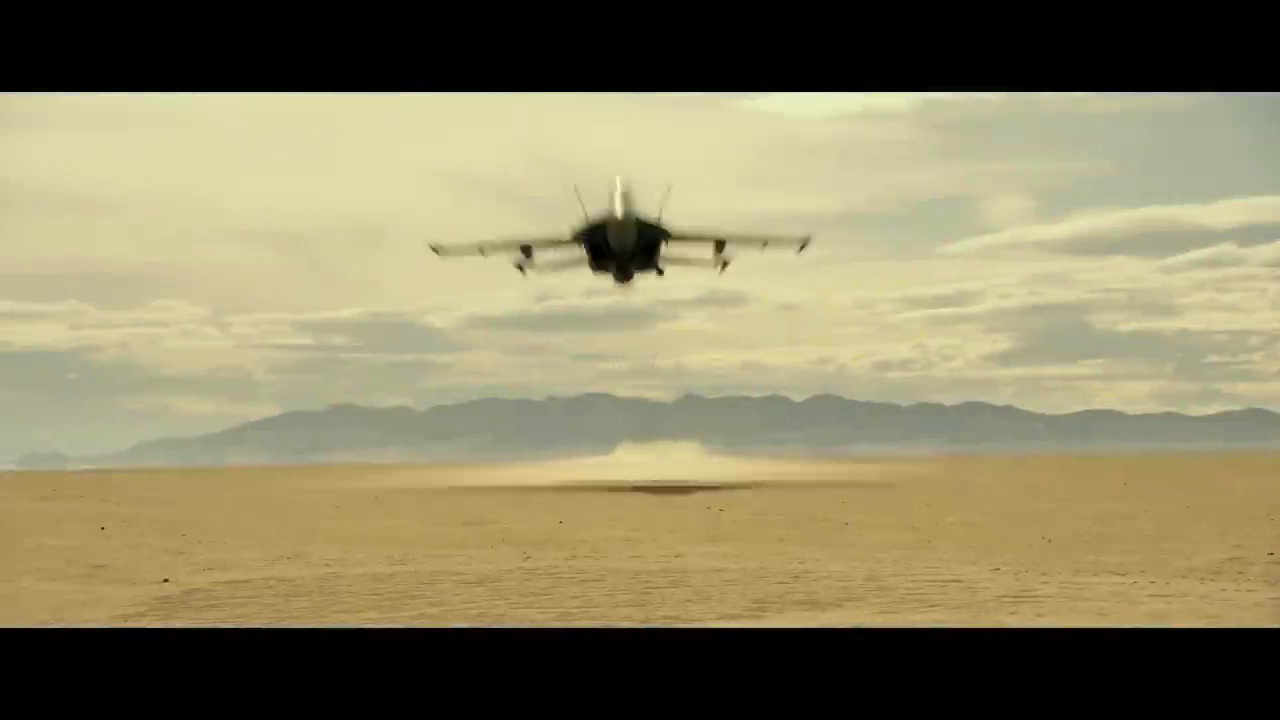

In [24]:
image_source, image = load_image('/content/drive/MyDrive/video_images/44.jpg')
Image.fromarray(image_source)

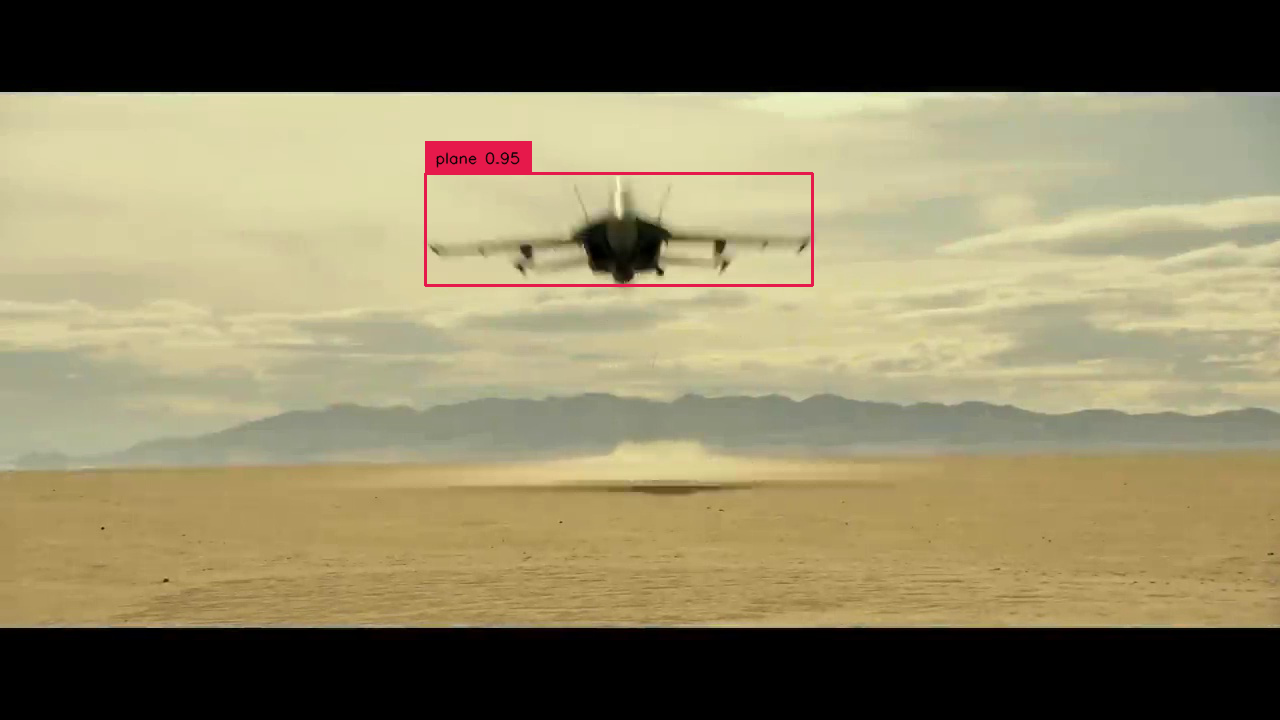

In [25]:
prompt = "plane"
annotated_frame, detected_boxes = detect(image, text_prompt=prompt, model=groundingdino_model)
Image.fromarray(annotated_frame)

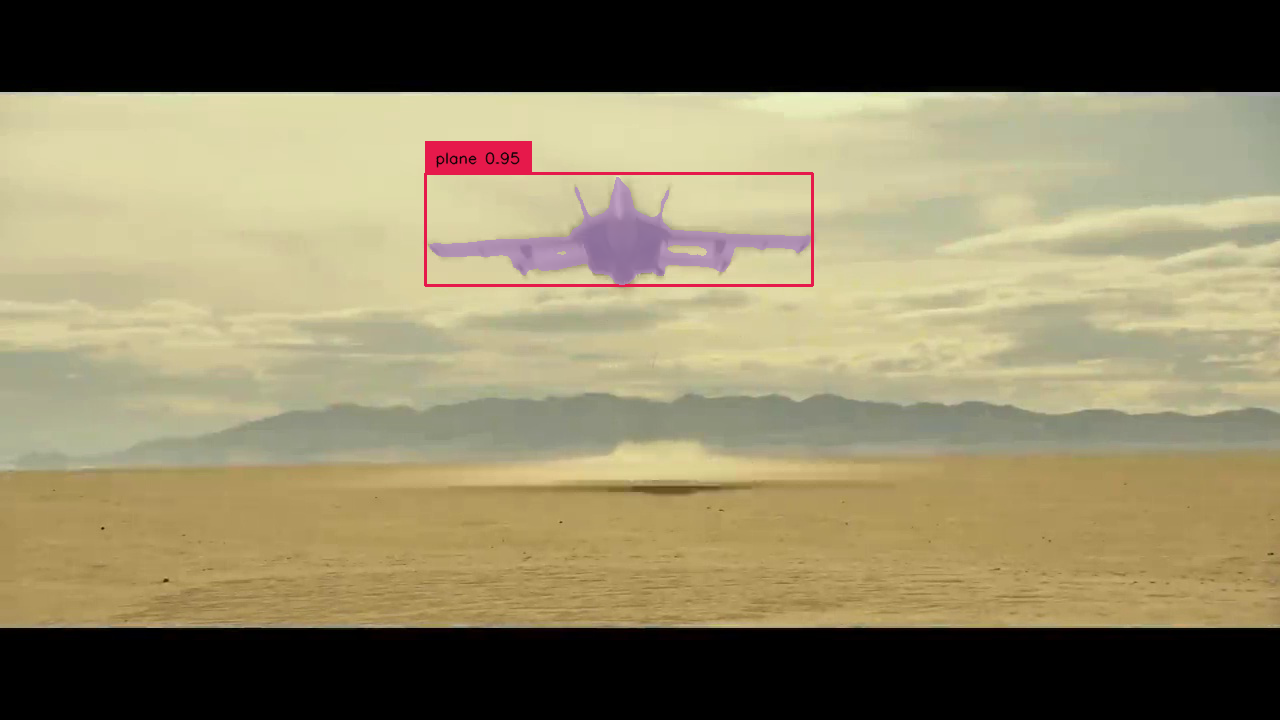

In [26]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

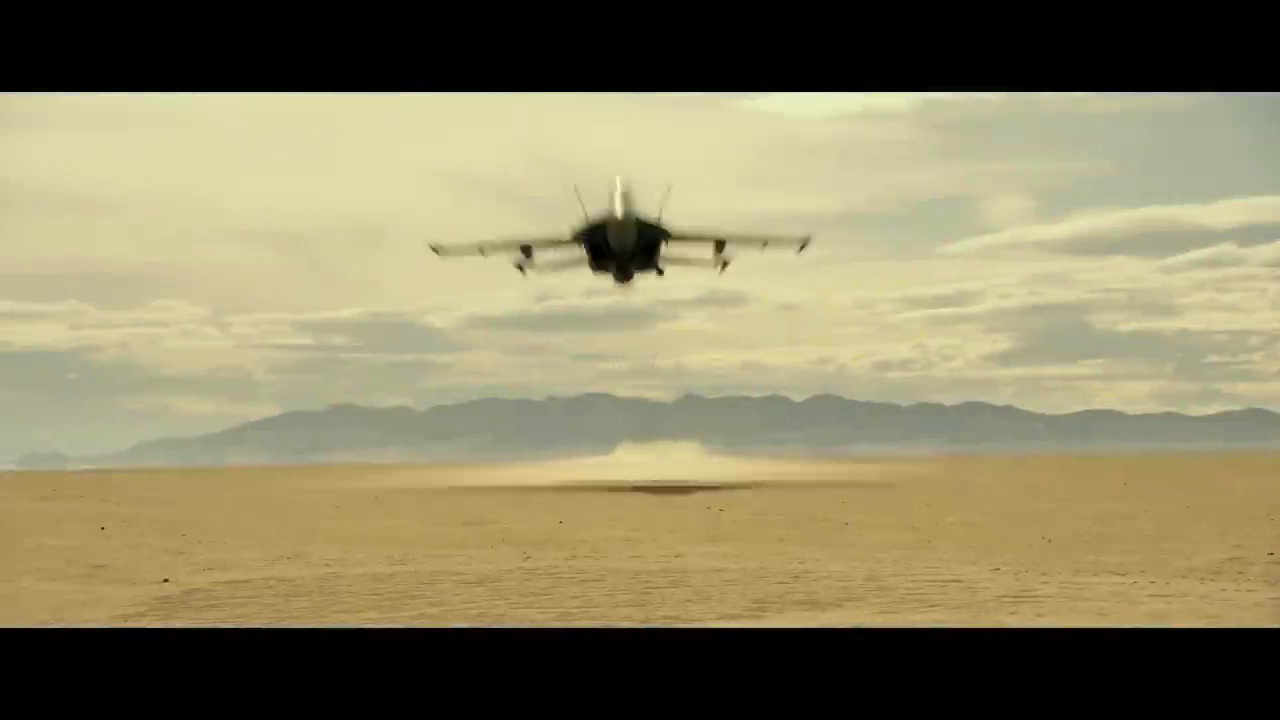

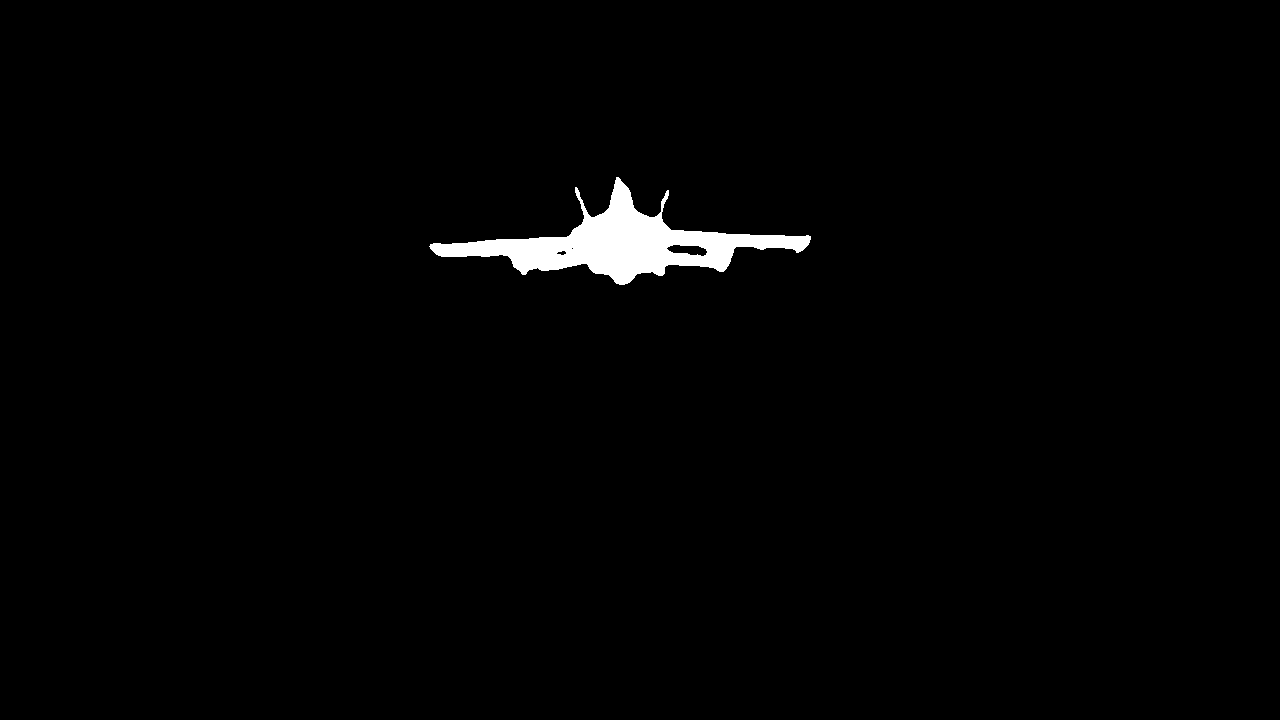

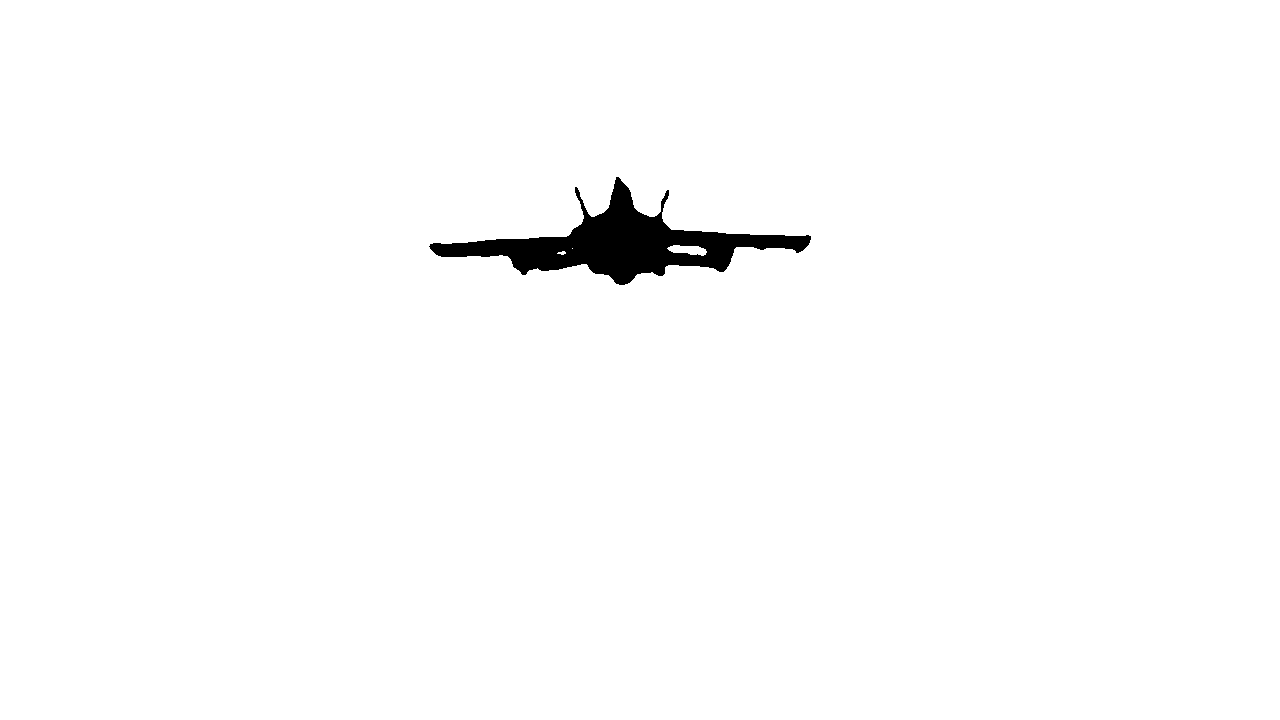

In [27]:
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

In [78]:
# import os

# path = '/content/drive/MyDrive/masks'
# if not os.path.exists(path):
#   os.mkdir(path)
# plt.imsave('/content/drive/MyDrive/masks/mask_temp.png',mask, cmap='gray')

# doing it for mutiple frames

In [28]:
os.path.basename(list_of_file_paths[0])

'0.jpg'

In [29]:
import os

path = '/content/drive/MyDrive/masks'
if not os.path.exists(path):
  os.mkdir(path)

In [30]:
list_of_file_paths

['/content/drive/MyDrive/video_images/0.jpg',
 '/content/drive/MyDrive/video_images/1.jpg',
 '/content/drive/MyDrive/video_images/2.jpg',
 '/content/drive/MyDrive/video_images/3.jpg',
 '/content/drive/MyDrive/video_images/4.jpg',
 '/content/drive/MyDrive/video_images/5.jpg',
 '/content/drive/MyDrive/video_images/6.jpg',
 '/content/drive/MyDrive/video_images/7.jpg',
 '/content/drive/MyDrive/video_images/8.jpg',
 '/content/drive/MyDrive/video_images/9.jpg',
 '/content/drive/MyDrive/video_images/10.jpg',
 '/content/drive/MyDrive/video_images/11.jpg',
 '/content/drive/MyDrive/video_images/12.jpg',
 '/content/drive/MyDrive/video_images/13.jpg',
 '/content/drive/MyDrive/video_images/14.jpg',
 '/content/drive/MyDrive/video_images/15.jpg',
 '/content/drive/MyDrive/video_images/16.jpg',
 '/content/drive/MyDrive/video_images/17.jpg',
 '/content/drive/MyDrive/video_images/18.jpg',
 '/content/drive/MyDrive/video_images/19.jpg',
 '/content/drive/MyDrive/video_images/20.jpg',
 '/content/drive/MyDriv

In [31]:
for index in range(len(list_of_file_paths)):
  single_path = list_of_file_paths[index]

  image_source, image = load_image(single_path)
  # prompt of what to find in image
  annotated_frame, detected_boxes = detect(image, text_prompt=prompt, model=groundingdino_model)

  segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
  annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)

  mask = segmented_frame_masks[0][0].cpu().numpy()
  inverted_mask = ((1 - mask) * 255).astype(np.uint8)


  image_source_pil = Image.fromarray(image_source)
  image_mask_pil = Image.fromarray(mask)
  inverted_image_mask_pil = Image.fromarray(inverted_mask)

  plt.imsave(f'/content/drive/MyDrive/masks/{index}.png',mask, cmap='gray')